In [ ]:
from utilities.setup_environment import *
from utilities.utilities import *
from utilities.plotting import *
from utilities.getStim import *
import matplotlib.cm as cm
import matplotlib.colors as mcolors
sns.set_context("poster")
import os
import re

In [2]:
df = pd.read_hdf('Data/TemporalNoise1f_v2.h5', key='data')
print(df['cell_type'].unique())
cell_type ='ON alpha'
cell_text = True
save = True


['OFF transient alpha' 'ON alpha' 'ON delayed' 'OFF sustained alpha']


In [3]:
psd_df = df.apply(lambda row: compute_psd_stats(row, fs=row['frame_rate']), axis=1)
results_all = pd.concat([df.reset_index(drop=True), psd_df], axis=1)
ctype_df = results_all.query(f"cell_type == '{cell_type}'").copy().reset_index(drop=True)
freqs = ctype_df['freqs'].iloc[0]
frame_rate = ctype_df['frame_rate'].iloc[0]
# Number of lags for autocorrelation
N_LAGS = 100
# Compute autocorrelations and store them in new columns
ctype_df['autocorr_spikes'] = ctype_df['spike_train'].apply(lambda x: autocorr_coeff(x, N_LAGS))
ctype_df['autocorr_stim'] = ctype_df['stimulus'].apply(lambda x: autocorr_coeff(x, N_LAGS))

In [4]:

cell_results = []
for cell_name in ctype_df['cell_name'].unique():
    cell_df = ctype_df[ctype_df['cell_name'] == cell_name]
    for beta_value in sorted(cell_df['beta'].unique()):
        data_for_beta = cell_df[cell_df['beta'] == beta_value]
        stim_psd = np.mean(np.stack(data_for_beta['Pxx_stim']), axis=0)
        stim_autocorr = np.mean(np.stack(data_for_beta['autocorr_stim']), axis=0)
        spikes_autocorr_rs = np.mean(np.stack(data_for_beta[data_for_beta['noise_seed'] == 1]['autocorr_spikes']), axis=0)
        spikes_autocorr_nr = np.mean(np.stack(data_for_beta[data_for_beta['noise_seed'] != 1]['autocorr_spikes']), axis=0)
        rs_spikes_psd = np.mean(np.stack(data_for_beta[data_for_beta['noise_seed'] == 1]['Pxx_spikes']), axis=0)
        nr_spikes_psd = np.mean(np.stack(data_for_beta[data_for_beta['noise_seed'] != 1]['Pxx_spikes']), axis=0)
        H_f_power_rs = np.mean(np.stack(data_for_beta[data_for_beta['noise_seed'] == 1]['H_f_pxx']), axis=0)
        H_f_power_nr = np.mean(np.stack(data_for_beta[data_for_beta['noise_seed'] != 1]['H_f_pxx']), axis=0)


        cell_results.append({
            'cell_type': data_for_beta['cell_type'].iloc[0],
            'cell_name': cell_name,
            'quadrant': data_for_beta['quadrant'].iloc[0],
            'freq': freqs,
            'beta': beta_value,
            'stim_psd': stim_psd,
            'rs_spikes_psd': rs_spikes_psd,
            'nr_spikes_psd': nr_spikes_psd,
            'H_f_power_rs': H_f_power_rs,
            'H_f_power_nr': H_f_power_nr,
            'stim_autocorr': stim_autocorr,
            'spikes_autocorr_rs': spikes_autocorr_rs,
            'spikes_autocorr_nr': spikes_autocorr_nr
            

        })

df_celltype = pd.DataFrame(cell_results)


In [5]:
for cell_name, group in df_celltype.groupby('cell_name'):
    quadrant = group['quadrant'].iloc[0]  # assuming one unique quadrant per cell
    print(f"Cell: {cell_name} → Quadrant: {quadrant}")


Cell: 032825Bc6 → Quadrant: VT
Cell: 042225Bc3 → Quadrant: VT
Cell: 052325Bc3 → Quadrant: DN


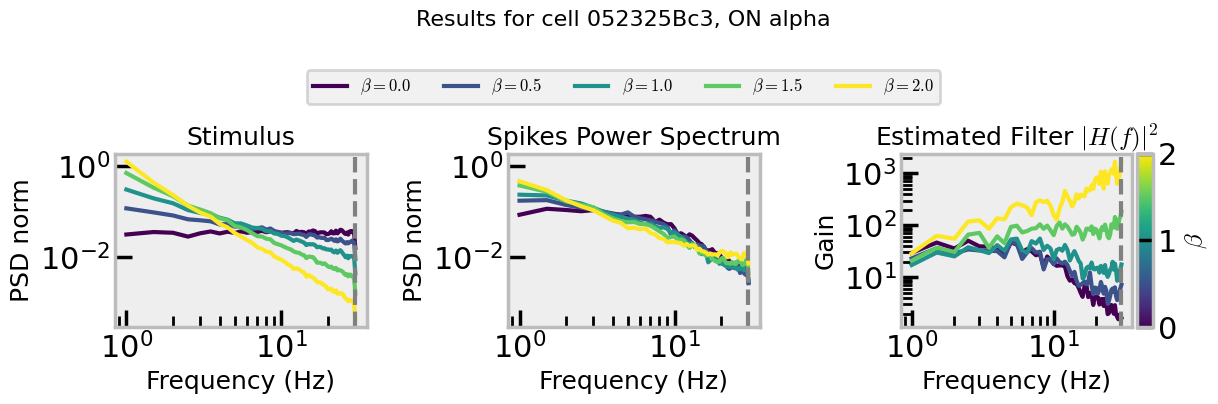

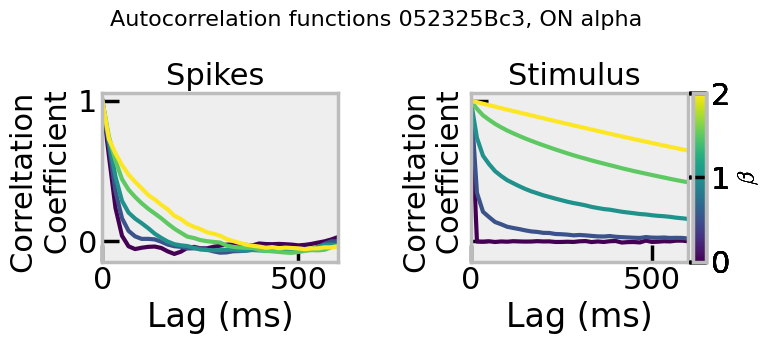

In [6]:
cell_name = '052325Bc3'
if cell_name in df_celltype['cell_name'].unique():
    fig, fig_corr = plot_example_cell(cell_name, df_celltype)

In [ ]:

safe_cell_type = re.sub(r'\W+', '_', cell_type.strip())
if save:
    df_celltype.to_csv(f'results/{safe_cell_type}_PSD_Gain.csv', index=False)
